# Leaf-level herbivory

Consider a leaf that is trying to maximize net carbon gain under the threat of herbivory. Let $LA(t)$ denote the leaf area, while $D(t)$ represents the concentration of defense compounds per unit area at time $t$. Each day, the gross carbon assimilated is $g(t) = g_0 LA(t)$ where $g_0$ represents daily gross carbon assimilation per unit area. Additionally, we represent herbivory (reduced by defense) by $h(D) = Re^{-KD}$. Suppose $CC_{def}$ represent the cost per one unit defense per unit area, defensive compounds breakdown at a rate $\gamma$ and that all of these parameters remain constant over the course of a day. Then we can represent the dynamics as
$$\Delta D(t) = \alpha(D, LA, t) - \delta \alpha(D, LA, t) ^ 2 - \gamma D$$
$$\Delta LA(t) = -h(D)LA$$

Where $\alpha(D, LA, t)$ represents defensive investment at defense concentration $D$, leaf area $LA$ and time $t$, with $\alpha(D, LA, t) \in [0, g(t)/LA]$ (e.g., defensive investment is split evenly across the leaf). We can define the daily net carbon assimilation as
$$K(LA(t), D(t), \alpha(D(t), LA(t), t)) = g_0 LA(t) - \alpha(D, LA, t) \cdot CC_{def} LA(t) = (g_0 - \alpha(D, LA, t) \cdot CC_{def}) LA(t)$$
Suppose the leaf survives for $T$ days, then the net future carbon assimilation at time $t$
$$J(LA, D, \alpha, t) = \sum^T_{i=t} K(LA(i), D(i), \alpha(D(t), LA(t), t))$$
Define the maximum potential net future carbon assimilation at time $t$ as
\begin{align*}
    u(LA(t), D(t), t) & = \sup_{\alpha(\cdot, \cdot, \cdot)} K(LA(i), D(i), \alpha(D(i), LA(i), i)) \\
                & = \max_{a \in [0, g_0]} K(LA(t), D(t), \alpha(D(t), LA(t), t)) + u(LA(t+1), D(t+1), t+1)
\end{align*}
Additionally, by defining $u(\cdot, \cdot, T+1) = 0$, we can solve backwards in time to obtain the optimal defense investment over the whole lifespan.

In [5]:
import numpy as np
import proplot as pplt
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm

In [222]:
# Model Parameters
T = 150         # Length of season
gamma = 0.05     # Rate of decay of defense
delta = 0.5
g_0 = 0.5      # Rate of production of new biomass per unit vegatative biomass
R = 0.15        # Background herbivory rate per unit biomass
K = 1         # Rate of decrease in herbviory as proportion of defense increases
cost = 1        # Cost of defense
save_dir = 'Example4'  # Name of directory to save intermediate results

def h(D):
    return R * np.exp(-K*D) 

def del_D(LA, D, a):
    return (a - gamma*D) * np.ones_like(LA)

def del_LA(LA, D, a):
    return -h(D) * LA

In [223]:
# Solver Parameters
# Define numerical bounds for space domain
LAmin = 0
LAmax =  40
LAnum = 500
h_LA = (LAmax - LAmin) / (LAnum-1)
LAs = np.linspace(LAmin, LAmax, LAnum).reshape(-1, 1)

Dmin = 0
Dmax = 40
Dnum = 500
h_D = (Dmax - Dmin) / (Dnum-1)
Ds = np.linspace(Dmin, Dmax, Dnum)

# Define numerical bounds for the control space
amin = 0
amax = g_0 
anum = 20
aa = np.linspace(amin, amax, anum)

# Initialize solutions for best value
big_num = 1_000_000        # A placeholder for infinity to ensure proper computations
U_future = np.zeros((LAnum, Dnum)) # Initialize final time step to 0

In [224]:
# Start from final time and solve backwards
with tqdm(total=T-1) as pbar:
    for n in range(T, -1, -1):
        BestVal = -np.inf * np.ones((LAs.size, Ds.size))
        # Set up interpolator to calculate value based on new position
        itpltr = RegularGridInterpolator((LAs.reshape(-1), Ds), U_future, method='linear')
        
        # Test out different control values to determine best trajectory
        for a in aa:
            # Calculate new positions under control choice a and interpolate the value function at the next step.
            new_Ds = Ds + del_D(LAs, Ds, a)
            new_LAs = LAs + del_LA(LAs, Ds, a)
            Val = []
            for row in range(len(new_Ds)):
                Val.append((g_0 - (a+delta*a**2)*cost)*LAs[row] + itpltr((new_LAs[row], new_Ds[row])))
            Val = np.array(Val)
            
            # Determine where this is the best choice
            new_best = (Val > BestVal)
            BestVal[new_best] = Val[new_best]
        
        # Save new calculated best choice
        np.save(f'Simulations/{save_dir}/U_{n+1}.npy', U_future)
        U_future = BestVal
        
        pbar.update(1)
    np.save(f'Simulations/{save_dir}/U_0.npy', U_future)

151it [02:50,  1.13s/it]                                                                                               


In [225]:
# Control synthesis - best choice based on interpolation of value function
def synthesis(LA_initial, D_initial):
    LA_current = LA_initial
    LA_traj = [LA_current]
    D_current = D_initial
    D_traj = [D_current]
    a_traj = []
    running_costs = []
    with tqdm(total=T-1) as pbar:
        for n in range(1, T):
        
            # Load next time layer
            U = np.load(f'Simulations/{save_dir}/U_{n}.npy')
            
            itpltr = RegularGridInterpolator((LAs.reshape(-1), Ds), U_future, method='linear')
            
            Best_value = -1
            Best_a = -1
            # Identify optimal control value
            for a in aa:
                # Calculate new positions
                LA_new = LA_current + del_LA(LA_current, D_current, a)
                D_new = D_current + del_D(LA_current, D_current, a)
                U_int = (g_0 - a*cost)*LA_current + itpltr((LA_new, D_new))
                
                if U_int > Best_value:
                    Best_value = U_int
                    Best_a = a
    
            # Use best control to update position
            running_costs.append((g_0 - Best_a*cost)*LA_current)
            LA_current = LA_current + del_LA(LA_current, D_current, Best_a)
            D_current = D_current + del_D(LA_current, D_current, Best_a)
            LA_traj.append(LA_current)
            D_traj.append(D_current)
            a_traj.append(Best_a)
            
            
            pbar.update(1)
    
    return LA_traj, D_traj, a_traj, running_costs

LA_traj, D_traj, a_traj, running_costs = synthesis(30, 0)

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:01<00:00, 91.03it/s]


<a list of 1 Line2D objects>

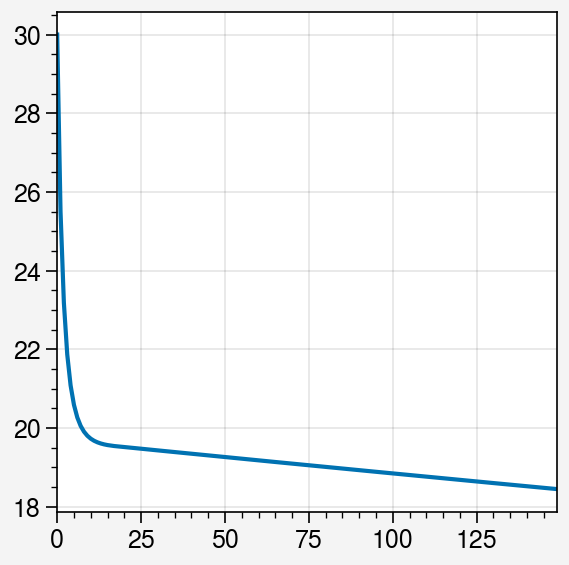

In [226]:
fig, ax = pplt.subplots(nrows=1, ncols=1)

ax.plot(range(T), LA_traj)

<a list of 1 Line2D objects>

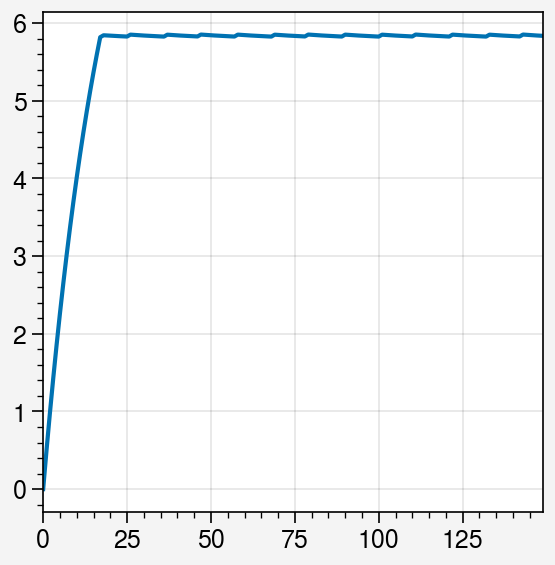

In [227]:
fig, ax = pplt.subplots(nrows=1, ncols=1)

ax.plot(range(T), D_traj)

<a list of 1 Line2D objects>

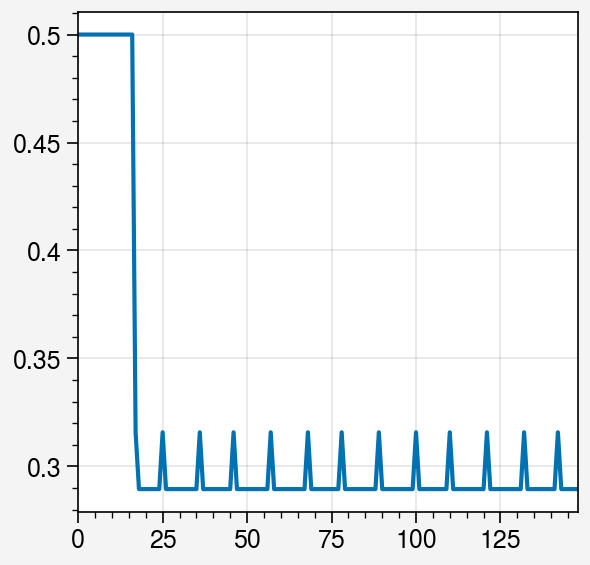

In [228]:
fig, ax = pplt.subplots(nrows=1, ncols=1)

ax.plot(range(T-1), a_traj)

<a list of 1 Line2D objects>

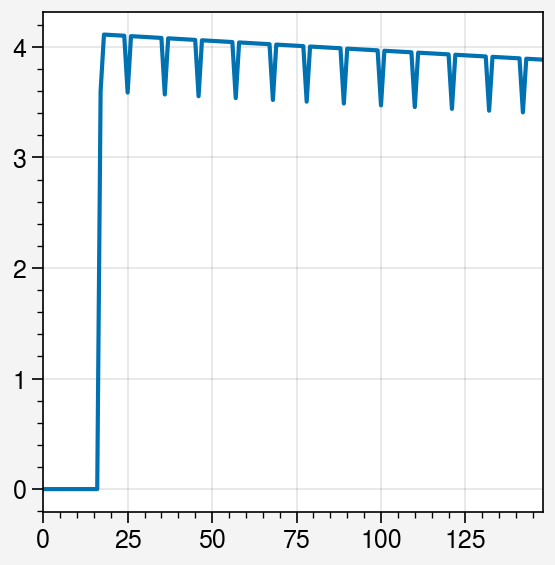

In [229]:
fig, ax = pplt.subplots(nrows=1, ncols=1)

ax.plot(range(T-1), running_costs)